In [1]:
from itertools import permutations
from keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D, Input, LeakyReLU
from keras.models import Model, Sequential
from keras.optimizers import SGD
from matplotlib import pyplot as plt
from sampling.RGBSampleCreator import RGBSampleCreator
from skimage.draw import circle
from sklearn.model_selection import train_test_split
from tools import *
import math
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns
import tensorflow as tf

C:\Users\User\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
img_size = (20, 20)
min_obj_size = 5
max_obj_size = 10
objs_count = 2
objs_variants = [
    ["square", "triangle"],
    ["square", "square"],
    ["triangle", "triangle"]
]
partial_count = int(4e3)
imgs_count = partial_count * len(objs_variants)
fake_objs = []
fake_prob = 0.90
max_interception = 2

creator = RGBSampleCreator(img_size, min_obj_size, max_obj_size)
sample_params = {
    "fake_objs": fake_objs,
    "max_interception": max_interception,
    "fake_prob": fake_prob
}

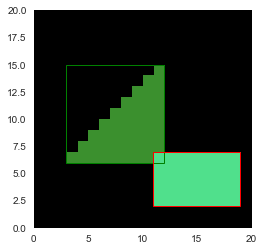

In [3]:
img = creator.create_sample(["square", "triangle"], **sample_params)
draw_rgbbbox(img[0] / 255, img[1], img[2])

In [4]:
"""Dataset generation"""
X = np.zeros((imgs_count, img_size[0], img_size[1], 3)) # X[i] - image with objects
y1 = np.zeros((imgs_count, objs_count, 4)) # y1[i] - list of bounding boxes
y2 = np.zeros((imgs_count, objs_count)) # y2[i] - list of class labels

for o, objs in enumerate(objs_variants):
    for i in range(partial_count * o, partial_count * (o+1)):
        sample = creator.create_sample(objs, **sample_params)
        X[i] = sample[0] / 255
        y1[i] = sample[1]
        y2[i] = sample[2]

# shuffle
p = np.random.permutation(imgs_count)
X = X[p]
y1 = y1[p]
y2 = y2[p]
print("Image data shape:", X.shape)
print("Bboxes data shape:", y1.shape)
print("Classes data shape:", y2.shape)

Image data shape: (12000, 20, 20, 3)
Bboxes data shape: (12000, 2, 4)
Classes data shape: (12000, 2)


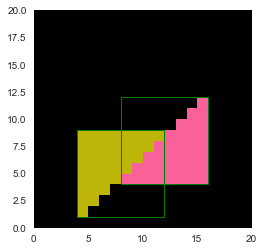

In [5]:
i = random.randint(0, imgs_count)
draw_rgbbbox(X[i], y1[i], y2[i])

In [6]:
# X = X.reshape((imgs_count, img_size[0] * img_size[1]))
y1 = y1.reshape((imgs_count, objs_count * 4))

In [7]:
train_size = int(imgs_count * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y1_train, y1_test = y1[:train_size], y1[train_size:]
y2_train, y2_test = y2[:train_size], y2[train_size:]
print("Train data shape:", X_train.shape, y1_train.shape, y2_train.shape)
print("Test data shape:", X_test.shape, y1_test.shape, y2_test.shape)

Train data shape: (9600, 20, 20, 3) (9600, 8) (9600, 2)
Test data shape: (2400, 20, 20, 3) (2400, 8) (2400, 2)


In [8]:
inp = Input((img_size[0], img_size[1], 3))

x = Conv2D(32, kernel_size=(3, 3), padding="same")(inp)
x = LeakyReLU()(x)
x = Conv2D(32, kernel_size=(3, 3))(x)
x = LeakyReLU()(x)
x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)
x = Dropout(0.25)(x)

x = Conv2D(64, kernel_size=(3, 3), padding="same")(x)
x = LeakyReLU()(x)
x = Conv2D(64, kernel_size=(3, 3))(x)
x = LeakyReLU()(x)
x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)
x = Dropout(0.25)(x)

x = Flatten()(x)

z1 = Dense(512, activation="relu")(x)
z1 = Dropout(0.25)(z1)
z1 = Dense(256, activation="relu")(z1)
z1 = Dropout(0.5)(z1)
z1 = Dense(objs_count * 4)(z1)
out1 = Activation("linear", name="regressor")(z1)

z2 = Dense(64, activation="relu")(x)
z2 = Dropout(0.25)(z2)
z2 = Dense(32, activation="relu")(z2)
z2 = Dropout(0.25)(z2)
z2 = Dense(objs_count)(z2)
out2 = Activation("sigmoid", name="classifier")(z2)

model = Model(inp, [out1, out2])
model.compile(optimizer="adadelta", loss="mse")
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 20, 20, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 20, 20, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 20, 20, 32)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 18, 18, 32)   9248        leaky_re_lu_1[0][0]              
__________________________________________________________________________________________________
leaky_re_l

In [9]:
num_epochs = 50
batch_size = 32

In [10]:
def custom_mse(y_pred, y_true):
    return np.mean(np.square(y_pred - y_true))

df_history = pd.DataFrame(columns=("loss", "val_loss", "regressor_loss",
                                   "val_regressor_loss", "classifier_loss",
                                   "val_classifier_loss"))
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1} of {num_epochs}")
    hist = model.fit(X_train, [y1_train, y2_train], batch_size=batch_size, epochs=1, validation_data=(X_test, [y1_test, y2_test]), verbose=2)
    hist_row = list()
    for c in df_history.columns:
        hist_row.append(hist.history[c][0])
    df_history.loc[len(df_history)] = hist_row
    
    # TODO: generalize
    y_pred = model.predict(X_train)
    flipped_y1_train = np.concatenate([y1_train[:, 4:], y1_train[:, :4]], axis=1)
    flipped_y2_train = np.concatenate([y2_train[:, 1:], y2_train[:, :1]], axis=1)
    mse = custom_mse(y_pred[0], y1_train)
    flipped_mse = custom_mse(y_pred[0], flipped_y1_train)
    if flipped_mse < mse:
        y1_train = flipped_y1_train
        y2_train = flipped_y2_train

Epoch 1 of 50
Train on 9600 samples, validate on 2400 samples
Epoch 1/1
 - 16s - loss: 15.1830 - regressor_loss: 14.9381 - classifier_loss: 0.2449 - val_loss: 10.4575 - val_regressor_loss: 10.2252 - val_classifier_loss: 0.2323
Epoch 2 of 50
Train on 9600 samples, validate on 2400 samples
Epoch 1/1
 - 13s - loss: 9.1895 - regressor_loss: 8.9787 - classifier_loss: 0.2108 - val_loss: 7.5024 - val_regressor_loss: 7.3568 - val_classifier_loss: 0.1456
Epoch 3 of 50
Train on 9600 samples, validate on 2400 samples
Epoch 1/1
 - 13s - loss: 8.3011 - regressor_loss: 8.1597 - classifier_loss: 0.1415 - val_loss: 7.2198 - val_regressor_loss: 7.1001 - val_classifier_loss: 0.1196
Epoch 4 of 50
Train on 9600 samples, validate on 2400 samples
Epoch 1/1
 - 13s - loss: 7.9417 - regressor_loss: 7.8127 - classifier_loss: 0.1290 - val_loss: 7.0168 - val_regressor_loss: 6.8955 - val_classifier_loss: 0.1212
Epoch 5 of 50
Train on 9600 samples, validate on 2400 samples
Epoch 1/1
 - 13s - loss: 7.7803 - regresso

Epoch 38 of 50
Train on 9600 samples, validate on 2400 samples
Epoch 1/1
 - 13s - loss: 4.8503 - regressor_loss: 4.7511 - classifier_loss: 0.0992 - val_loss: 7.8800 - val_regressor_loss: 7.7693 - val_classifier_loss: 0.1108
Epoch 39 of 50
Train on 9600 samples, validate on 2400 samples
Epoch 1/1
 - 13s - loss: 4.8427 - regressor_loss: 4.7444 - classifier_loss: 0.0983 - val_loss: 7.7867 - val_regressor_loss: 7.6834 - val_classifier_loss: 0.1033
Epoch 40 of 50
Train on 9600 samples, validate on 2400 samples
Epoch 1/1
 - 13s - loss: 4.7760 - regressor_loss: 4.6799 - classifier_loss: 0.0962 - val_loss: 7.5906 - val_regressor_loss: 7.4931 - val_classifier_loss: 0.0975
Epoch 41 of 50
Train on 9600 samples, validate on 2400 samples
Epoch 1/1
 - 13s - loss: 4.6810 - regressor_loss: 4.5857 - classifier_loss: 0.0953 - val_loss: 7.9439 - val_regressor_loss: 7.8450 - val_classifier_loss: 0.0990
Epoch 42 of 50
Train on 9600 samples, validate on 2400 samples
Epoch 1/1
 - 13s - loss: 4.5933 - regress

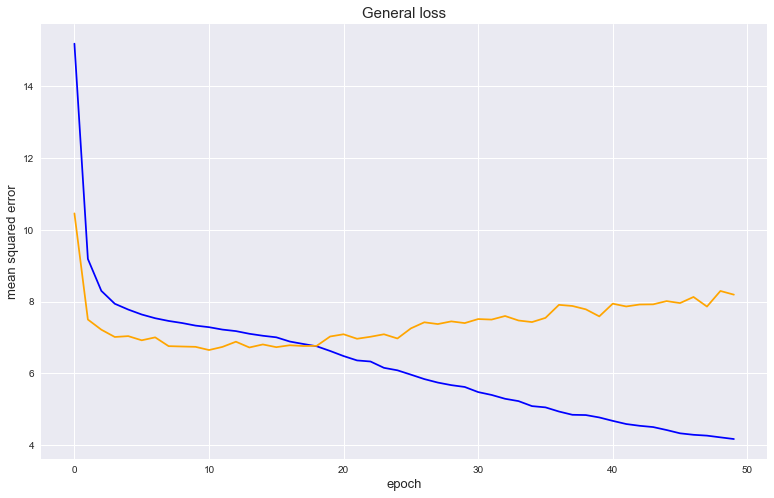

In [11]:
sns.set(style="darkgrid")
f = plt.figure(figsize=(13, 8))
plt.plot(df_history["loss"], c="blue", label="train")
plt.plot(df_history["val_loss"], c="orange", label="val")
plt.title("General loss", fontsize=15)
plt.xlabel("epoch", fontsize=13)
plt.ylabel("mean squared error", fontsize=13)
plt.show()

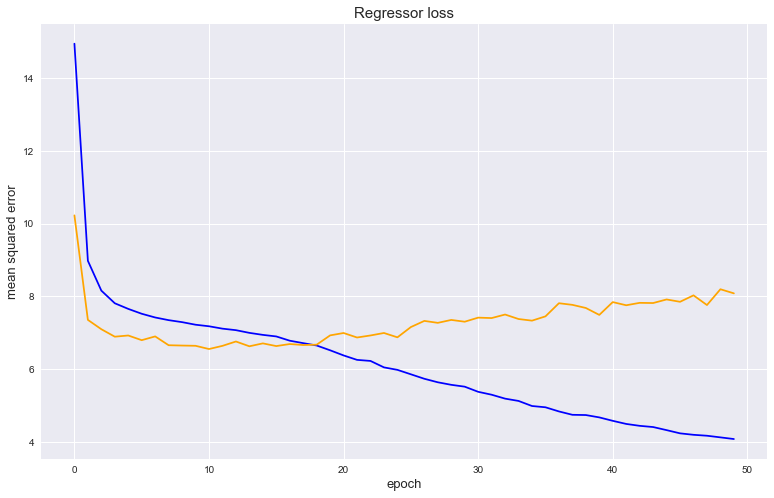

In [12]:
sns.set(style="darkgrid")
f = plt.figure(figsize=(13, 8))
plt.plot(df_history["regressor_loss"], c="blue", label="train")
plt.plot(df_history["val_regressor_loss"], c="orange", label="val")
plt.title("Regressor loss", fontsize=15)
plt.xlabel("epoch", fontsize=13)
plt.ylabel("mean squared error", fontsize=13)
plt.show()

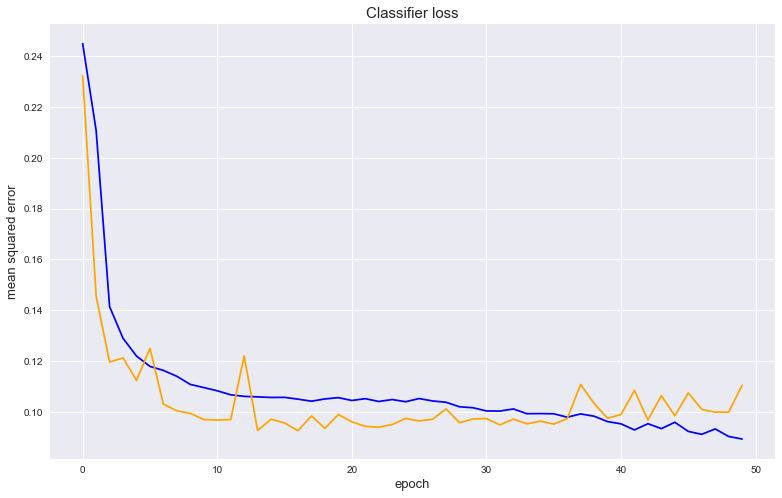

In [13]:
sns.set(style="darkgrid")
f = plt.figure(figsize=(13, 8))
plt.plot(df_history["classifier_loss"], c="blue", label="train")
plt.plot(df_history["val_classifier_loss"], c="orange", label="val")
plt.title("Classifier loss", fontsize=15)
plt.xlabel("epoch", fontsize=13)
plt.ylabel("mean squared error", fontsize=13)
plt.show()

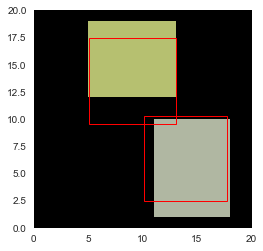

In [14]:
# Evaluate on a training sample
sample = X_train[random.randint(0, X_train.shape[0])]
pred = model.predict(sample.reshape((1, img_size[0], img_size[1], 3)))
y1_pred = pred[0].reshape((int(pred[0].shape[1] / 4), 4))
y2_pred = list(map(round, pred[1].flatten()))
draw_rgbbbox(sample, y1_pred, y2_pred)

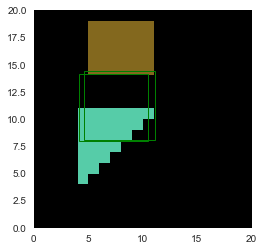

In [15]:
# Evaluate on a new sample
sample = creator.create_sample(["triangle", "square"], **sample_params)[0] / 255
pred = model.predict(sample.reshape((1, img_size[0], img_size[1], 3)))
y1_pred = pred[0].reshape((int(pred[0].shape[1] / 4), 4))
y2_pred = list(map(round, pred[1].flatten()))
draw_rgbbbox(sample, y1_pred, y2_pred)